In [13]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import toeplitz as sp_toeplitz

from scipy.sparse.linalg import LinearOperator
from numpy.fft import fft, ifft

import jlinops

In [71]:
def toeplitz_linear_operator(first_column, first_row):
    n = len(first_column)  # Number of rows
    m = len(first_row)     # Number of columns
    p = max(n, m)          # Size of the embedding circulant matrix (at least as large as the longest dimension)

    # Check if the first element of first_column and first_row is the same
    if first_column[0] != first_row[0]:
        raise ValueError("The first element of first_column and first_row must be the same.")

    # Create the embedding circulant matrix's first column
    c = np.concatenate((first_column, np.zeros(p - n)))
    r = np.concatenate((first_row, np.zeros(p - m)))
    circulant_first_col = np.concatenate((c, r[-1:0:-1]))

    circulant_first_col_fft = fft(circulant_first_col, n=2*p - 1)  # FFT with padding

    def matvec(v):
        if len(v) != m:
            raise ValueError("Vector length must match the number of columns of the Toeplitz matrix.")
        v_padded = np.concatenate((v, np.zeros(2*p - 1 - m)))
        v_fft = fft(v_padded)
        result_fft = circulant_first_col_fft * v_fft
        result = np.real(ifft(result_fft))
        return result[:n]

    return LinearOperator((n, m), matvec=matvec)


In [72]:

# Example Usage for a rectangular Toeplitz matrix
first_column = np.array([1, 2, 3, 4])  # First column of the Toeplitz matrix
first_row = np.array([1, 5, 6])       # First row of the Toeplitz matrix
T = toeplitz_linear_operator(first_column, first_row)
v = np.array([7, 8, 9])               # Vector for multiplication
result = T @ v                        # Perform the matrix-vector multiplication
print(result)


[101.  67.  46.  70.]


In [73]:
jlinops.black_box_to_dense(T)

array([[1., 5., 6.],
       [2., 1., 5.],
       [3., 2., 1.],
       [4., 3., 2.]])

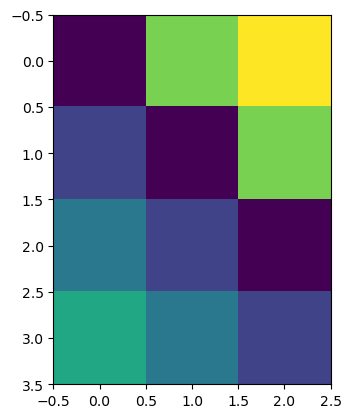

In [74]:
plt.imshow(jlinops.black_box_to_dense(T))
plt.show()

# Operator

In [92]:
from jlinops import _CustomLinearOperator, get_device

In [93]:
class ToeplitzOperator(_CustomLinearOperator):
    """Represents a circulant LinearOperator.
    """
    def __init__(self, first_column, first_row=None):
        
        n = len(first_column)  # Number of rows
        device = get_device(first_column) # get device

        # Make symmetric if first_row is not given
        if first_row is None:
            first_row = first_column

        m = len(first_row)     # Number of columns
        p = max(n, m)          # Size of the embedding circulant matrix (at least as large as the longest dimension)
        shape = (n, m)         # Shape

        # Check if the first element of first_column and first_row is the same
        if first_column[0] != first_row[0]:
            raise ValueError("The first element of first_column and first_row must be the same.")

        # Store column
        self.first_column = first_column
        self.first_row = first_row

        if device == "cpu":

            # Setup
            c = np.concatenate((first_column, np.zeros(p - n)))
            r = np.concatenate((first_row, np.zeros(p - m)))
            circulant_first_col = np.concatenate((c, r[-1:0:-1]))
            circulant_first_col_fft = fft(circulant_first_col, n=2*p - 1)  # FFT with padding
            
            adjoint_first_col = np.concatenate((first_row[::-1], np.zeros(p - m)))
            adjoint_first_row = np.concatenate((first_column[::-1], np.zeros(p - n)))
            adjoint_circulant_first_col = np.concatenate((adjoint_first_col, adjoint_first_row[-1:0:-1]))
            adjoint_circulant_first_col_fft = fft(adjoint_circulant_first_col, n=2*p - 1)


            def _matvec(v):
                if len(v) != m:
                    raise ValueError("Vector length must match the number of columns of the Toeplitz matrix.")
                v_padded = np.concatenate((v, np.zeros(2*p - 1 - m)))
                v_fft = fft(v_padded)
                result_fft = circulant_first_col_fft * v_fft
                result = np.real(ifft(result_fft))
                return result[:n]
            
            def _rmatvec(v):
                if len(v) != n:
                    raise ValueError("Vector length must match the number of rows of the Toeplitz matrix.")
                v_padded = np.concatenate((v, np.zeros(2*p - 1 - n)))
                v_fft = fft(v_padded)
                result_fft = adjoint_circulant_first_col_fft * v_fft
                result = np.real(ifft(result_fft))
                return result[:m]


        else:

            pass
        

        super().__init__(shape, _matvec, rmatvec=_rmatvec, device=device)



    #     # shape
    #     n = len(self.column)

    #     # Get device
    #     device = get_device(self.column)

    #     if device == "cpu":
            
    #         self.first_col_fft = fft(first_column)
    #         self.first_col_fft_conj = np.conj(self.first_col_fft)

    #         def _matvec(v):
    #             v_fft = fft(v)
    #             result_fft = self.first_col_fft * v_fft  # Element-wise multiplication
    #             return np.real(ifft(result_fft))  # Inverse FFT and take the real part
            
    #         def _rmatvec(v):
    #             v_fft = fft(v)
    #             result_fft = self.first_col_fft_conj * v_fft
    #             return np.real(ifft(result_fft))
            
    #     else:

    #         self.first_col_fft = fft(first_column)
    #         self.first_col_fft_conj = np.conj(self.first_col_fft)

    #         def _matvec(v):
    #             v_fft = fft(v)
    #             result_fft = self.first_col_fft * v_fft  # Element-wise multiplication
    #             return np.real(ifft(result_fft))  # Inverse FFT and take the real part
            
    #         def _rmatvec(v):
    #             v_fft = fft(v)
    #             result_fft = self.first_col_fft_conj * v_fft
    #             return np.real(ifft(result_fft))

    #     super().__init__((n,n), _matvec, _rmatvec, device=device)

    # def to_gpu(self):
    #     return ToeplitzOperator(cp.asarray(self.column))
    
    # def to_cpu(self):
    #     return ToeplitzOperator(cp.asnumpy(self.column))

In [94]:
T = ToeplitzOperator(np.random.normal(size=5))

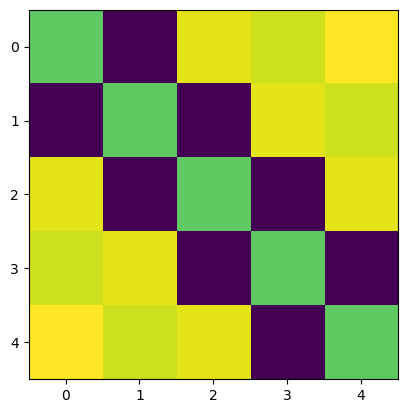

In [95]:
plt.imshow( jlinops.black_box_to_dense(T) )
plt.show()

In [96]:
first_col = np.random.normal(size=5)
first_row = np.random.normal(size=7)
first_row[0] = first_col[0]
T = ToeplitzOperator(first_row, first_col)

In [97]:
T

<7x5 ToeplitzOperator with dtype=float64>

In [98]:
jlinops.check_adjoint(T)

False

In [9]:
def random_toeplitz_matrix(n, which="matrix"):
    """Generates a random circulant matrix.
    """
    
    # Draw random column vector
    col = np.random.normal(size=n)

    if which == "matrix":
        return sp_toeplitz(col)

    # elif which == "operator":
    #     return CirculantOperator(col)

    else:
        raise NotImplementedError

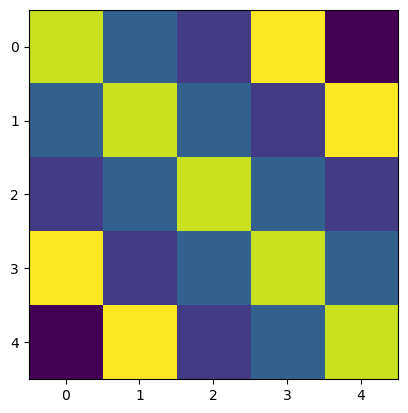

In [11]:
plt.imshow(random_toeplitz_matrix(5))
plt.show()